# Union tutorial on masks
There are some geometries that are impossible to build using only the priority based system geometry system, for example making part of a cylinder thinner, which is needed for a cryostat window. In many such cases, masks can be used to solve the problem.

In [1]:
import mcstasscript as ms

In [2]:
instrument = ms.McStas_instr("python_tutorial", input_path="run_folder")

### Setting up an example without masks
First we set up an example with a thick and hollow Al cylinder and a logger to view the spatial distribution of scattering.

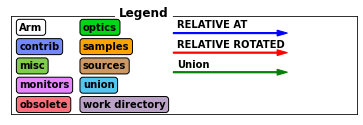

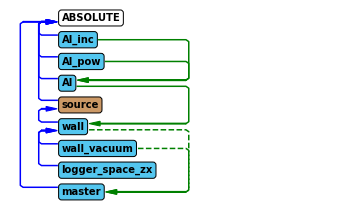

In [3]:
Al_inc = instrument.add_component("Al_inc", "Incoherent_process")
Al_inc.sigma = 0.0082
Al_inc.unit_cell_volume = 66.4

Al_pow = instrument.add_component("Al_pow", "Powder_process")
Al_pow.reflections = '"Al.laz"'

Al = instrument.add_component("Al", "Union_make_material")
Al.process_string = '"Al_inc,Al_pow"'
Al.my_absorption = 100*0.231/66.4 # barns [m^2 E-28]*Å^3 [m^3 E-30]=[m E-2], factor 100

src = instrument.add_component("source", "Source_div")

src.xwidth = 0.2
src.yheight = 0.035
src.focus_aw = 0.01
src.focus_ah = 0.01


src.lambda0 = instrument.add_parameter("wavelength", value=5.0,
                                       comment="Wavelength in [Ang]")
src.dlambda = "0.01*wavelength"
src.flux = 1E13

wall = instrument.add_component("wall", "Union_cylinder")
wall.set_AT([0,0,1], RELATIVE=src)
wall.yheight = 0.15
wall.radius = 0.1
wall.material_string='"Al"' 
wall.priority = 10

wall_vac = instrument.add_component("wall_vacuum", "Union_cylinder")
wall_vac.set_AT([0,0,0], RELATIVE=wall)
wall_vac.yheight = 0.15 + 0.01
wall_vac.radius = 0.1 - 0.02
wall_vac.material_string='"Vacuum"' 
wall_vac.priority = 50

logger_zx = instrument.add_component("logger_space_zx", "Union_logger_2D_space")
logger_zx.set_RELATIVE(wall)
logger_zx.D_direction_1 = '"z"'
logger_zx.D1_min = -0.12
logger_zx.D1_max = 0.12
logger_zx.n1 = 300
logger_zx.D_direction_2 = '"x"'
logger_zx.D2_min = -0.12
logger_zx.D2_max = 0.12
logger_zx.n2 = 300
logger_zx.filename = '"logger_zx.dat"'

master = instrument.add_component("master", "Union_master")

instrument.show_diagram()

In the above diagram it is clear that the wall is made of Al and the master simulates the wall and the wall_vacuum.

In [4]:
instrument.settings(ncount=2E6, output_path="data_folder/union_masks")

data = instrument.backengine()

INFO: Using directory: "/Users/madsbertelsen/PaNOSC/McStasScript/github/McStasScript/docs/source/tutorial/data_folder/union_masks_98"
INFO: Regenerating c-file: python_tutorial.c
CFLAGS= -I@MCCODE_LIB@/share/
INFO: Recompiling: ./python_tutorial.out
mccode-r.c:2837:3: warning: expression result unused [-Wunused-value]
  *t0;
  ^~~
In file included from /Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1//contrib/union/Incoherent_process.comp:65:
/Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1//share/Union_functions.c:1604:105: warning: incompatible pointer types passing 'int (const struct saved_history_struct *, const struct saved_history_struct *)' to parameter of type 'int (* _Nonnull)(const void *, const void *)' [-Wincompatible-pointer-types]
  qsort(total_history.saved_histories,total_history.used_elements,sizeof (struct saved_history_struct), Sample_compare_history_intensities);
                                                                            

Plotting data with name logger_space_zx


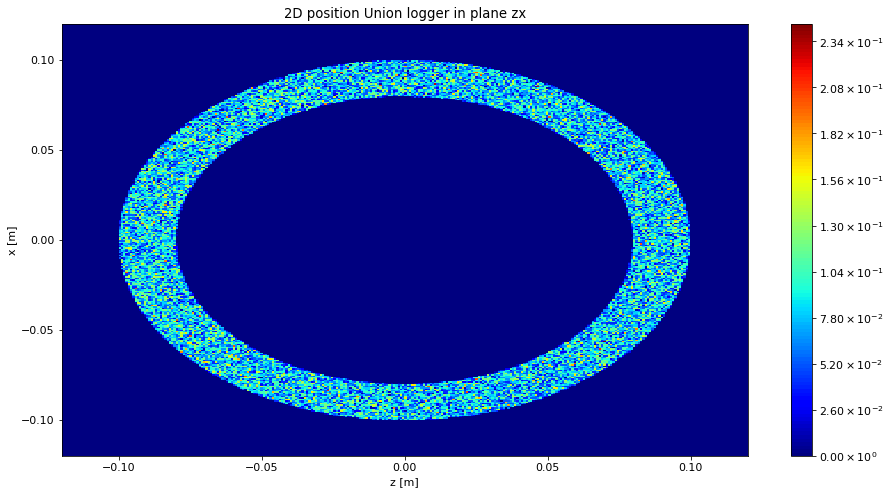

In [5]:
ms.make_sub_plot(data)

## Masks
All Union geometries can act as a mask for a list of other already defined geometries. The geometries affected by a mask will only exist inside the mask, while the parts outside will not have any effect on this simulation. This provides some interesting geometrical capabilities, for example by defining two spheres with some overlap and making one a mask of the other, a classical lens shape can be created.

The relevant parameters of all geometry components are:
- mask_string : comma separated list of geometry names the mask should be applied to
- mask_setting : selects between "ANY" or "ALL" mode. Default mode is "ALL".

The mask mode is only important if several masks affect the same geometry, per default just having any of the masks overlap the target geometry allow it to exists, which correspond to the "ANY" mode. If the "ALL" mode is selected, the target geometry will only exists in regions where all the masks and itself overlap.

Note that a unique priority is still necessary, but it is not used.

## Adding a window using masks
Here we add a window to one side of the cylinder by inserting a larger vacuum cylinder, but mask it so that it is only active in the area around the window. In this way we get a nice curved window. We chose a box shape for the mask, but we could also have chosen a cylinder to get a round window.

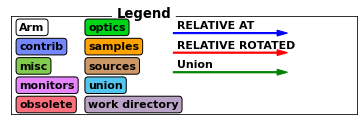

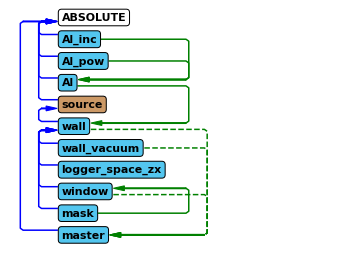

In [6]:
window = instrument.add_component("window", "Union_cylinder", before="master")
window.set_AT([0,0,0], RELATIVE=wall)
window.yheight = 0.15 + 0.02
window.radius = 0.1 - 0.01
window.material_string='"Vacuum"' 
window.priority = 25

mask = instrument.add_component("mask", "Union_box", before="master")
mask.xwidth = 0.1
mask.yheight = 0.2
mask.zdepth = 0.09
mask.priority = 1
mask.mask_string='"window"'
mask.set_AT([0,0,-0.1], RELATIVE=wall)

instrument.show_diagram()

The windows was added to the diagram and is connected to the master as expected. The mask shows up as a component that only acts on the window geometry, as the mask itself is not simulated, it just modifies the window.

In [7]:
data = instrument.backengine()

INFO: Using directory: "/Users/madsbertelsen/PaNOSC/McStasScript/github/McStasScript/docs/source/tutorial/data_folder/union_masks_99"
INFO: Regenerating c-file: python_tutorial.c
CFLAGS= -I@MCCODE_LIB@/share/
INFO: Recompiling: ./python_tutorial.out
mccode-r.c:2837:3: warning: expression result unused [-Wunused-value]
  *t0;
  ^~~
In file included from /Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1//contrib/union/Incoherent_process.comp:65:
/Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1//share/Union_functions.c:1604:105: warning: incompatible pointer types passing 'int (const struct saved_history_struct *, const struct saved_history_struct *)' to parameter of type 'int (* _Nonnull)(const void *, const void *)' [-Wincompatible-pointer-types]
  qsort(total_history.saved_histories,total_history.used_elements,sizeof (struct saved_history_struct), Sample_compare_history_intensities);
                                                                            

Plotting data with name logger_space_zx


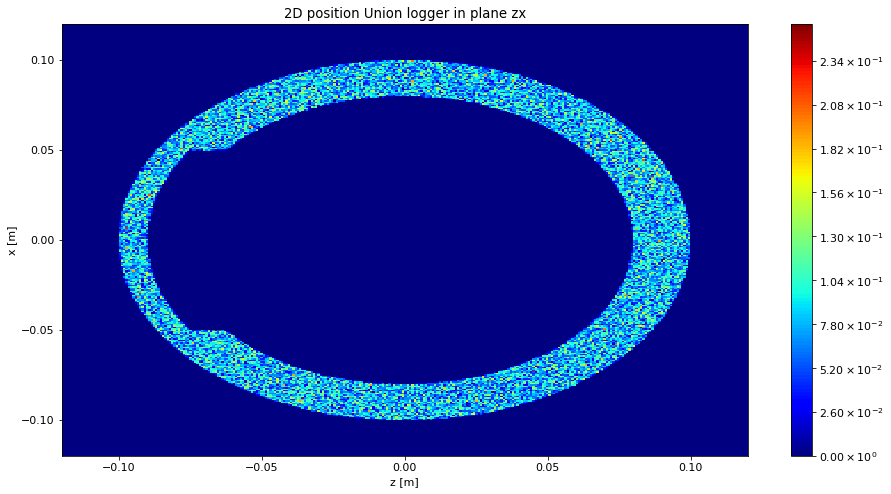

In [8]:
ms.make_sub_plot(data)

## Adding an external window using a mask
It is also possible to create a thinner section where the material is reduced from the outside. Here we need to add both a vacuum and an aluminium geometry, both of which need to have a priority lower than the original inner vacuum. One mask can handle several geometries, just include both names in the *mask_string* parameter.

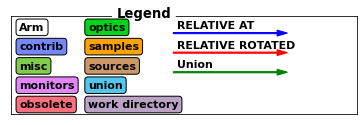

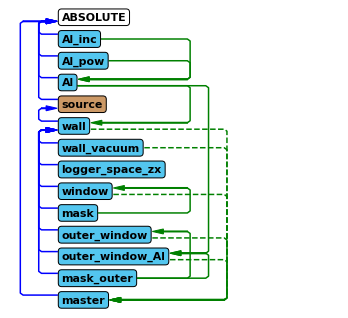

In [9]:
o_window = instrument.add_component("outer_window", "Union_cylinder", before="master")
o_window.set_AT([0,0,0], RELATIVE=wall)
o_window.yheight = 0.15 + 0.03
o_window.radius = 0.1 + 0.01
o_window.material_string='"Vacuum"' 
o_window.priority = 30

o_window_al = instrument.add_component("outer_window_Al", "Union_cylinder", before="master")
o_window_al.set_AT([0,0,0], RELATIVE=wall)
o_window_al.yheight = 0.15 + 0.04
o_window_al.radius = 0.1 - 0.01
o_window_al.material_string='"Al"' 
o_window_al.priority = 31

mask = instrument.add_component("mask_outer", "Union_box", before="master")
mask.xwidth = 0.12
mask.yheight = 0.2
mask.zdepth = 0.09
mask.priority = 2
mask.mask_string='"outer_window,outer_window_Al"'
mask.set_AT([0,0,0.1], RELATIVE=wall)

instrument.show_diagram()

For the outer window the mask_outer acts on two geometries, outer_window and outer_window_Al. Notice that both the arrow for Al and mask_outer go to outer_window_Al as they both impact that component, one as a material and the other as a mask.

In [10]:
data = instrument.backengine()

INFO: Using directory: "/Users/madsbertelsen/PaNOSC/McStasScript/github/McStasScript/docs/source/tutorial/data_folder/union_masks_100"
INFO: Regenerating c-file: python_tutorial.c
CFLAGS= -I@MCCODE_LIB@/share/
INFO: Recompiling: ./python_tutorial.out
mccode-r.c:2837:3: warning: expression result unused [-Wunused-value]
  *t0;
  ^~~
In file included from /Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1//contrib/union/Incoherent_process.comp:65:
/Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1//share/Union_functions.c:1604:105: warning: incompatible pointer types passing 'int (const struct saved_history_struct *, const struct saved_history_struct *)' to parameter of type 'int (* _Nonnull)(const void *, const void *)' [-Wincompatible-pointer-types]
  qsort(total_history.saved_histories,total_history.used_elements,sizeof (struct saved_history_struct), Sample_compare_history_intensities);
                                                                           

Plotting data with name logger_space_zx


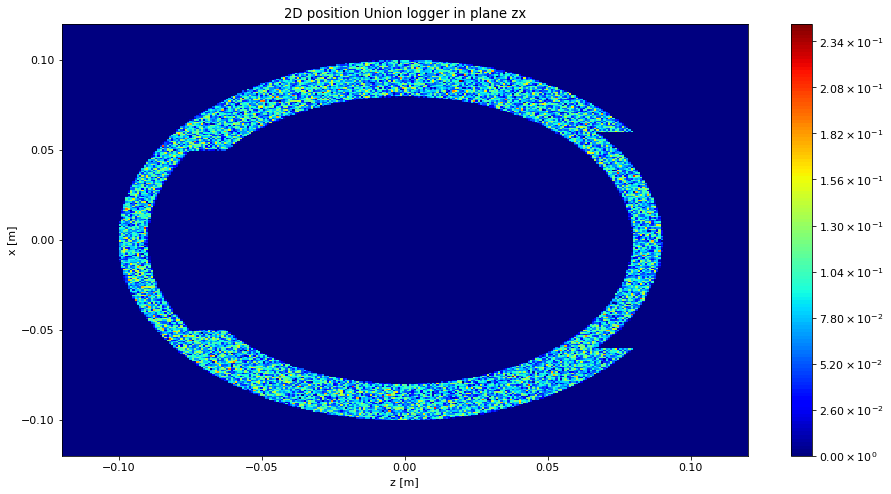

In [11]:
ms.make_sub_plot(data)

### Masks are flexible
Masks can be used to create many interesting shapes with few geometries. Below we create a octagon with rounded corners using just three geometries, two of these being masks. Using masks expands the space of possible geometries greatly, and in many cases can also be a performance advantage when they reduce the number of geometries needed to describe the desired geometry.

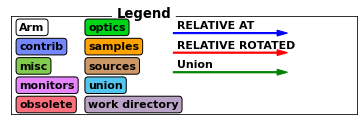

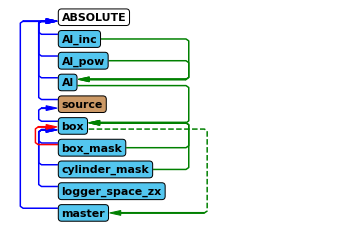

In [12]:
instrument = ms.McStas_instr("python_tutorial", input_path="run_folder")

Al_inc = instrument.add_component("Al_inc", "Incoherent_process")
Al_inc.sigma = 0.0082
Al_inc.unit_cell_volume = 66.4

Al_pow = instrument.add_component("Al_pow", "Powder_process")
Al_pow.reflections = '"Al.laz"'

Al = instrument.add_component("Al", "Union_make_material")
Al.process_string = '"Al_inc,Al_pow"'
Al.my_absorption = 100*0.231/66.4 # barns [m^2 E-28]*Å^3 [m^3 E-30]=[m E-2], factor 100

src = instrument.add_component("source", "Source_div")

src.xwidth = 0.2
src.yheight = 0.035
src.focus_aw = 0.01
src.focus_ah = 0.01

instrument.add_parameter("wavelength", value=5.0, comment="Wavelength in [Ang]")
src.lambda0="wavelength"
src.dlambda="0.01*wavelength"
src.flux = 1E13

box = instrument.add_component("box", "Union_box")
box.set_AT([0,0,1], RELATIVE=src)
box.xwidth = 0.2
box.yheight = 0.1
box.zdepth = 0.2
box.material_string='"Al"' 
box.priority = 10

# Cut the corners by using an identical box rotated 45 deg around y
box_mask = instrument.add_component("box_mask", "Union_box")
box_mask.set_AT([0,0,0], RELATIVE=box)
box_mask.set_ROTATED([0,45,0], RELATIVE=box)
box_mask.xwidth = 0.2
box_mask.yheight = 0.11 # Have to increase yheight to avoid perfect overlap
box_mask.zdepth = 0.2
box_mask.mask_string='"box"' 
box_mask.priority = 50

# Round the corners with a cylinder mask
cyl_mask = instrument.add_component("cylinder_mask", "Union_cylinder")
cyl_mask.set_AT([0,0,0], RELATIVE=box)
cyl_mask.radius = 0.105
cyl_mask.yheight = 0.12
cyl_mask.mask_string='"box"' 
cyl_mask.priority = 51

logger_zx = instrument.add_component("logger_space_zx", "Union_logger_2D_space")
logger_zx.set_RELATIVE(box)
logger_zx.D_direction_1 = '"z"'
logger_zx.D1_min = -0.12
logger_zx.D1_max = 0.12
logger_zx.n1 = 300
logger_zx.D_direction_2 = '"x"'
logger_zx.D2_min = -0.12
logger_zx.D2_max = 0.12
logger_zx.n2 = 300
logger_zx.filename = '"logger_zx.dat"'

master = instrument.add_component("master", "Union_master")


instrument.show_diagram()

In [13]:
data = instrument.backengine()

INFO: Using directory: "/Users/madsbertelsen/PaNOSC/McStasScript/github/McStasScript/docs/source/tutorial/python_tutorial_data_37"
INFO: Regenerating c-file: python_tutorial.c
CFLAGS= -I@MCCODE_LIB@/share/
INFO: Recompiling: ./python_tutorial.out
mccode-r.c:2837:3: warning: expression result unused [-Wunused-value]
  *t0;
  ^~~
In file included from /Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1//contrib/union/Incoherent_process.comp:65:
/Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1//share/Union_functions.c:1604:105: warning: incompatible pointer types passing 'int (const struct saved_history_struct *, const struct saved_history_struct *)' to parameter of type 'int (* _Nonnull)(const void *, const void *)' [-Wincompatible-pointer-types]
  qsort(total_history.saved_histories,total_history.used_elements,sizeof (struct saved_history_struct), Sample_compare_history_intensities);
                                                                               

Plotting data with name logger_space_zx


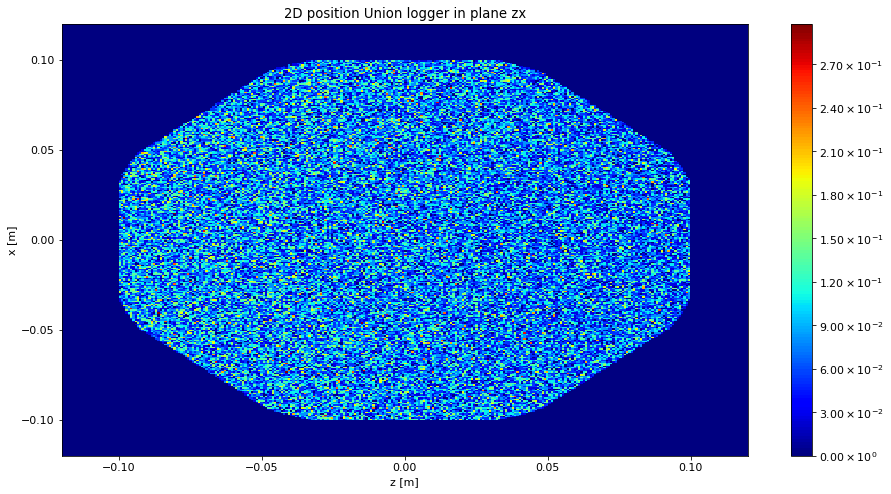

In [14]:
ms.make_sub_plot(data)